In [1]:
import torch

from mlcolvar.cvs import KANDeepTDA

# IMPORT PACKAGES
import torch
import lightning
import numpy as np
import matplotlib.pyplot as plt

# IMPORT HELPER FUNCTIONS
from mlcolvar.utils.plot import muller_brown_potential, plot_isolines_2D, plot_metrics

# Set seed for reproducibility
torch.manual_seed(42)

/home/etrizio@iit.local/Bin/miniconda3/envs/mlcvs_test/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [57]:
from mlcolvar.utils.io import create_dataset_from_files
from mlcolvar.data import DictModule

n_states = 2
filenames = [ f"data/muller-brown/unbiased/state-{i}/COLVAR" for i in range(n_states) ]

# load dataset
dataset, df = create_dataset_from_files(filenames,return_dataframe=True, filter_args={'regex':'p.x|p.y'})

# create datamodule for trainere
datamodule = DictModule(dataset,lengths=[0.8,0.2])
datamodule

Class 0 dataframe shape:  (2001, 13)
Class 1 dataframe shape:  (2001, 13)

 - Loaded dataframe (4002, 13): ['time', 'p.x', 'p.y', 'p.z', 'ene', 'pot.bias', 'pot.ene_bias', 'lwall.bias', 'lwall.force2', 'uwall.bias', 'uwall.force2', 'walker', 'labels']
 - Descriptors (4002, 2): ['p.x', 'p.y']


DictModule(dataset -> DictDataset( "data": [4002, 2], "labels": [4002] ),
		     train_loader -> DictLoader(length=0.8, batch_size=0, shuffle=True),
		     valid_loader -> DictLoader(length=0.2, batch_size=0, shuffle=True))

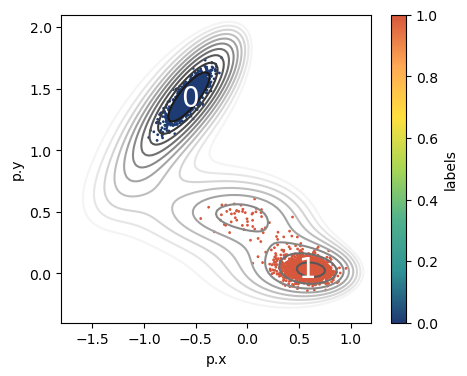

In [58]:
fig,ax = plt.subplots(figsize=(5,4),dpi=100)
# ploy MB isolines
plot_isolines_2D(muller_brown_potential,mode='contour',levels=np.linspace(0,24,12),ax=ax)
# plot points colored according to labels
df.plot.scatter('p.x','p.y',c='labels',s=1,cmap='fessa',ax=ax)
# draw state labels
for i in range(n_states):
    df_g = df.groupby('labels').mean()
    ax.text(x = df_g['p.x'].values[i]-0.075, 
            y = df_g['p.y'].values[i]-0.075,
            s = str(i), size=20, color='white')

In [63]:
# Parameters
n_cvs = 1
target_centers = [-7, 7]
target_sigmas = [0.4, 0.4]
nn_layers = [2,10,1]

# Initialize DeepTDA model
model = KANDeepTDA(n_states=n_states, n_cvs=1,target_centers=target_centers, target_sigmas=target_sigmas, layers=nn_layers)

In [64]:
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from mlcolvar.utils.trainer import MetricsCallback

# define callbacks
metrics = MetricsCallback()
# early_stopping = EarlyStopping(monitor="valid_loss", mode='min', min_delta=1e-2, patience=20)

# define trainer
trainer = lightning.Trainer(callbacks=[metrics],
                     max_epochs=600, logger=None, enable_checkpointing=False)

# fit
trainer.fit( model, datamodule )

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type          | Params | In sizes | Out sizes
-----------------------------------------------------------------
0 | loss_fn | TDALoss       | 0      | ?        | ?        
1 | norm_in | Normalization | 0      | [1, 2]   | [1, 2]   
2 | KAN     | KAN           | 300    | [1, 2]   | [1, 1]   
-----------------------------------------------------------------
300       Trainable params
0         Non-trainable params
300       Total params
0.001     Total estimated model params size (MB)


/home/etrizio@iit.local/Bin/miniconda3/envs/mlcvs_test/lib/python3.10/site-packages/lightning/pytorch/loops/fit_loop.py:280: PossibleUserWarning: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 599: 100%|██████████| 1/1 [00:00<00:00, 60.19it/s, v_num=42] 

`Trainer.fit` stopped: `max_epochs=600` reached.


Epoch 599: 100%|██████████| 1/1 [00:00<00:00, 56.08it/s, v_num=42]


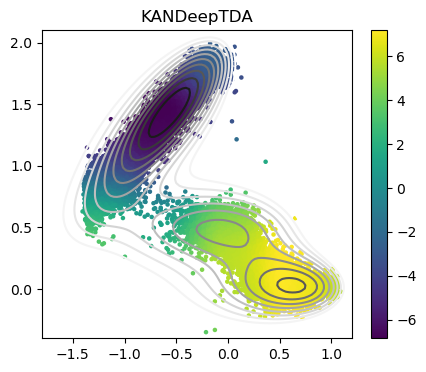

In [65]:
from mlcolvar.utils.io import load_dataframe
fig,ax = plt.subplots( 1, 1, figsize=(5,4) )

plot_isolines_2D(muller_brown_potential,levels=np.linspace(0,24,12),mode='contour',ax=ax)


reactive = "data/muller-brown/unbiased/high-temp/COLVAR"
reactive = ["data/muller-brown/unbiased/high-temp/COLVAR", "data/muller-brown/biased/opes-y/COLVAR", "data/muller-brown/biased/opes-x/COLVAR", "data/muller-brown/biased/explore-x/COLVAR", ]
df = load_dataframe(reactive)
data = torch.Tensor(df.filter(regex="p.x|p.y").values)
out = model(data)

cp = plt.scatter(data[:, 0].detach().numpy(), data[:, 1].detach().numpy(), c=out.detach().numpy(), s=5)
plt.colorbar(cp)
ax.set_title('KANDeepTDA')
plt.show()

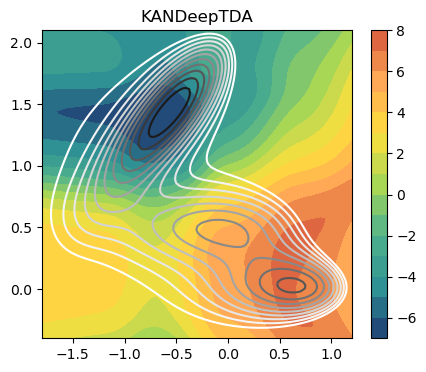

In [66]:
fig,ax = plt.subplots( 1, 1, figsize=(5,4) )

plot_isolines_2D(muller_brown_potential,levels=np.linspace(0,24,12),mode='contour',ax=ax)
plot_isolines_2D(model, levels=15, ax=ax)
ax.set_title('KANDeepTDA')
plt.show()

In [67]:
traced_model = model.to_torchscript('trace')

AssertionError: Unsupported annotation typing.Union[list, torch.Tensor] could not be resolved because None could not be resolved.

# Three states

In [51]:
n_states = 3
filenames = [ f"data/muller-brown-3states/unbiased/state-{i}/COLVAR" for i in range(n_states) ]

# load dataset
dataset, df = create_dataset_from_files(filenames,return_dataframe=True, filter_args={'regex':'p.x|p.y'})

# create datamodule for trainere
datamodule = DictModule(dataset,lengths=[0.8,0.2])
datamodule

Class 0 dataframe shape:  (2001, 13)
Class 1 dataframe shape:  (2001, 13)
Class 2 dataframe shape:  (2001, 13)

 - Loaded dataframe (6003, 13): ['time', 'p.x', 'p.y', 'p.z', 'ene', 'pot.bias', 'pot.ene_bias', 'lwall.bias', 'lwall.force2', 'uwall.bias', 'uwall.force2', 'walker', 'labels']
 - Descriptors (6003, 2): ['p.x', 'p.y']


DictModule(dataset -> DictDataset( "data": [6003, 2], "labels": [6003] ),
		     train_loader -> DictLoader(length=0.8, batch_size=0, shuffle=True),
		     valid_loader -> DictLoader(length=0.2, batch_size=0, shuffle=True))

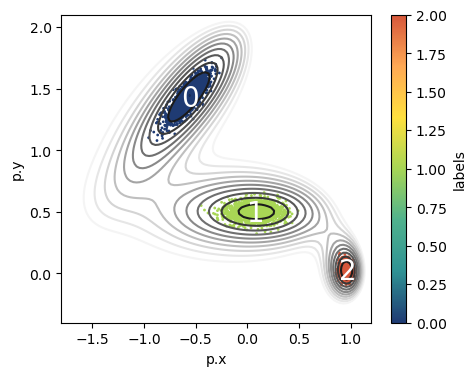

In [52]:
from mlcolvar.utils.plot import muller_brown_potential_three_states

fig,ax = plt.subplots(figsize=(5,4),dpi=100)
# ploy MB isolines
plot_isolines_2D(muller_brown_potential_three_states,mode='contour',levels=np.linspace(0,24,12),ax=ax)
# plot points colored according to labels
df.plot.scatter('p.x','p.y',c='labels',s=1,cmap='fessa',ax=ax)
# draw state labels
for i in range(n_states):
    df_g = df.groupby('labels').mean()
    ax.text(x = df_g['p.x'].values[i]-0.075, 
            y = df_g['p.y'].values[i]-0.075,
            s = str(i), size=20, color='white')

In [53]:
n_cvs = 1
target_centers = [-14,0,14]
target_sigmas = [0.4, 0.4, 0.4]
nn_layers = [2,10, 10, 1]
# MODEL
# options = {'KAN' : {"base_activation" : torch.nn.ReLU}}
model = KANDeepTDA(n_states=n_states, n_cvs=1,target_centers=target_centers, target_sigmas=target_sigmas, layers=nn_layers)

In [54]:
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from mlcolvar.utils.trainer import MetricsCallback

# define callbacks
metrics = MetricsCallback()
# early_stopping = EarlyStopping(monitor="valid_loss", mode='min', min_delta=1e-2, patience=20)

# define trainer
trainer = lightning.Trainer(callbacks=[metrics],
                     max_epochs=800, logger=None, enable_checkpointing=False)

# fit
trainer.fit( model, datamodule )

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type          | Params | In sizes | Out sizes
-----------------------------------------------------------------
0 | loss_fn | TDALoss       | 0      | ?        | ?        
1 | norm_in | Normalization | 0      | [1, 2]   | [1, 2]   
2 | KAN     | KAN           | 1.3 K  | [1, 2]   | [1, 1]   
-----------------------------------------------------------------
1.3 K     Trainable params
0         Non-trainable params
1.3 K     Total params
0.005     Total estimated model params size (MB)


/home/etrizio@iit.local/Bin/miniconda3/envs/mlcvs_test/lib/python3.10/site-packages/lightning/pytorch/loops/fit_loop.py:280: PossibleUserWarning: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 799: 100%|██████████| 1/1 [00:00<00:00, 47.94it/s, v_num=40] 

`Trainer.fit` stopped: `max_epochs=800` reached.


Epoch 799: 100%|██████████| 1/1 [00:00<00:00, 44.76it/s, v_num=40]


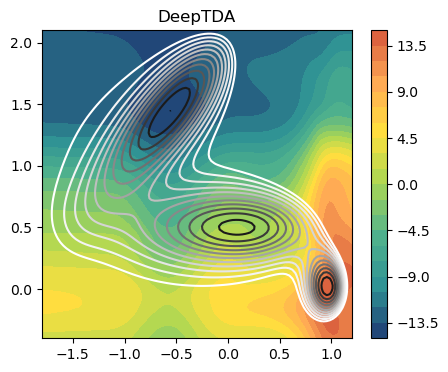

In [56]:
fig,ax = plt.subplots( 1, 1, figsize=(5,4) )

plot_isolines_2D(muller_brown_potential_three_states,levels=np.linspace(0,24,12),mode='contour',ax=ax)
plot_isolines_2D(model, levels=25, ax=ax)
ax.set_title('DeepTDA')
plt.show()

# TPI-TDA

In [29]:
from mlcolvar.utils.io import create_dataset_from_files
from mlcolvar.data import DictModule

filenames = [ "data/muller-brown/unbiased/state-0/COLVAR",
              "data/muller-brown/biased/opes-flooding/combined_ts.dat",
              "data/muller-brown/unbiased/state-1/COLVAR"]

n_states = len(filenames)

# load dataset
# here we only load part of the data to speed up the training, change stop to 25000 and stride to 1 to use them all for better results
dataset, df = create_dataset_from_files(filenames,
                                        create_labels=True,
                                        return_dataframe=True,
                                        filter_args={'regex':'p.x|p.y' }, # select distances between heavy atoms
                                        stop=1600,
                                        stride=1)

datamodule = DictModule(dataset,lengths=[0.8,0.2])

Class 0 dataframe shape:  (1600, 13)
Class 1 dataframe shape:  (1600, 8)
Class 2 dataframe shape:  (1600, 13)

 - Loaded dataframe (4800, 16): ['time', 'p.x', 'p.y', 'p.z', 'ene', 'pot.bias', 'pot.ene_bias', 'lwall.bias', 'lwall.force2', 'uwall.bias', 'uwall.force2', 'walker', 'labels', 'deepTDA.node-0', 'mueller', 'opes.bias']
 - Descriptors (4800, 2): ['p.x', 'p.y']


In [46]:
n_cvs = 1
target_centers = [-7,0,7]
target_sigmas = [0.4, 1.5, 0.4]
nn_layers = [2,10,10,1]
# MODEL
model = KANDeepTDA(n_states=n_states, n_cvs=1,target_centers=target_centers, target_sigmas=target_sigmas, layers=nn_layers)

In [47]:
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from mlcolvar.utils.trainer import MetricsCallback

# define callbacks
metrics = MetricsCallback()
# early_stopping = EarlyStopping(monitor="valid_loss", mode='min', min_delta=1e-2, patience=20)

# define trainer
trainer = lightning.Trainer(callbacks=[metrics],
                     max_epochs=800, logger=None, enable_checkpointing=False)

# fit
trainer.fit( model, datamodule )

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type          | Params | In sizes | Out sizes
-----------------------------------------------------------------
0 | loss_fn | TDALoss       | 0      | ?        | ?        
1 | norm_in | Normalization | 0      | [1, 2]   | [1, 2]   
2 | KAN     | KAN           | 1.3 K  | [1, 2]   | [1, 1]   
-----------------------------------------------------------------
1.3 K     Trainable params
0         Non-trainable params
1.3 K     Total params
0.005     Total estimated model params size (MB)


Epoch 799: 100%|██████████| 1/1 [00:00<00:00, 50.40it/s, v_num=39]          

`Trainer.fit` stopped: `max_epochs=800` reached.


Epoch 799: 100%|██████████| 1/1 [00:00<00:00, 47.55it/s, v_num=39]


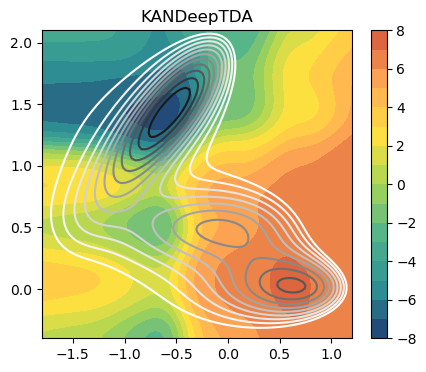

In [48]:
fig,ax = plt.subplots( 1, 1, figsize=(5,4) )

plot_isolines_2D(muller_brown_potential,levels=np.linspace(0,24,12),mode='contour',ax=ax)
plot_isolines_2D(model, levels=15, ax=ax)
ax.set_title('KANDeepTDA')
plt.show()

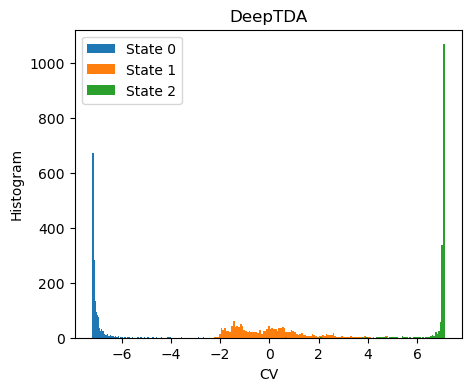

In [50]:
fig,ax = plt.subplots( 1, 1, figsize=(5,4) )

X = dataset[:]['data']
Y = dataset[:]['labels']

with torch.no_grad():
    s = model(torch.Tensor(X)).numpy()
    
for i in range(n_states):
    s_red = s[torch.nonzero(Y==i, as_tuple=True)]
    ax.hist(s_red[:,0],bins=100, label=f'State {i}')

ax.set_xlabel(f'CV')
ax.set_ylabel('Histogram')
ax.set_title('DeepTDA')
plt.legend()
plt.show()